In [1]:
import csv
import numpy as np
import pandas as pd
import pickle
import random 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot
import glob
from matplotlib import colors

In [2]:
ORDER_CASE = [
    "ANN", "NAN", "NNA", "NDN", "DNN", "NND",
    "NAA", "AAN", "ANA", "ADA", "DAA", "AAD",
    "DDN", "DND", "NDD", "ADD", "DDA", "DAD",
] 
MAGIC_INDEX = {
    w: i for w, i in zip(ORDER_CASE, range(0, 2000, 6))
}
BASE_CASE_ASSIGNMENT = {
    "NAD": 0,
    "NDA": 1,
    "AND": 2,
    "ADN": 3,
    "DNA": 4,
    "DAN": 5,
}
REV_BASE_CASE_ASSIGNMENT = {j:i for i,j 
                            in BASE_CASE_ASSIGNMENT.items()}

In [3]:
def get_one_letter_diff(word):
    violations = []
    letters = ["A", "D", "N"]
    for letter_1 in letters:
        for letter_2 in letters:
            if letter_1 != letter_2:
                violations.append(word.replace(letter_1, letter_2))                
    return violations    

def get_all_violations(global_idx):
    """global idx is 1 indexed, goes up to 7200"""
    template = (global_idx) // 36
    idx = global_idx % 36
    
    word_order = idx % 6
    base_case_assignment = REV_BASE_CASE_ASSIGNMENT[idx // 6]
    violations = get_one_letter_diff(base_case_assignment)
    violations = [MAGIC_INDEX[v] + word_order for v in violations]
    
    start = template * 108 
    return [v + start + 1800  for v in violations ]

In [4]:
get_one_letter_diff('AND')


['DND', 'NND', 'ANA', 'ANN', 'AAD', 'ADD']

In [5]:
get_all_violations(0)

[1884, 1830, 1836, 1806, 1866, 1902]

In [8]:
GRAMMATICAL_TXT = "data/grammatical_sentences.txt"
UNGRAMMATICAL_TXT = "data/ungrammatical_sentences.txt"

def load_lines(path):
    with open(path) as infile:
        return infile.read().splitlines()
    
gram_lines = load_lines(GRAMMATICAL_TXT)
ungram_lines = load_lines(UNGRAMMATICAL_TXT)

        

In [9]:
idx = 1799
print("Gram:")
print(gram_lines[idx])
print("Violations:")
print("\n".join([ungram_lines[i] for i in get_all_violations(idx)]))


Gram:
Wir wissen, dass ein Zwang den Erzeuger dem Kommissar auferlegt hat.
Violations:


IndexError: list index out of range

In [10]:
gram_lines[0]

'Wir wissen, dass der Mann seinen Bruder einem Schrank gegeben hat.'

## Load matrices of sentences indexes

In [11]:
def pickle_load(path):
    with open(path, "rb") as fp:
        loaded_file = pickle.load(fp)
    return loaded_file

In [12]:
grammaticality = pickle_load("mTurk/mTurk_grammaticality_matrix.txt") 
meaning = pickle_load("mTurk/mTurk_meaningfulness_matrix.txt")

## Results: Grammar

### Get scores: 1 vs 6

In [13]:
grammar_base_path = "/Users/charlotterochereau/Documents/Stage_ENS/mTurk/mTurk_results/mTurk_grammar_results/"
meaning_base_path = "/Users/charlotterochereau/Documents/Stage_ENS/mTurk/mTurk_results/mTurk_meaning_results/"

ANS_COLS_GRAM = ([f'Q1_{i}'for i in range(1, 11)] + [f'Q2_{i}' for i in range(2, 12)] + 
                 [f'Q3_{i}' for i in range(2, 12)] + [f'Q8_{i}' for i in range(1, 11)] +
                 [f'Q9_{i}' for i in range(2, 12)])

MEANING_COLS_GRAM = ([f'Q1_{i}' for i in range(1, 11)] + [f'Q2_{i}' for i in range(1, 11)] + 
                [f'Q3_{i}' for i in range(1, 11)] + [f'Q1_{i}.1' for i in range(1, 11)] +
                 [f'Q2_{i}' for i in range(2, 12)])

def gram_grades_per_person(path):
    ranks = pd.read_csv(path)
    ranks = ranks[ANS_COLS_GRAM]
    return ranks.iloc[-1]

def meaning_grades_per_person(path):
    ranks = pd.read_csv(path)
    ranks = ranks[MEANING_COLS_GRAM]
    return ranks.iloc[-1]

def get_all_gram_grades(base_path):
    all_ranks = []
    for filename in glob.glob(base_path + "Grammar_*.csv"):
        idx = int(filename.split('/')[-1].split('.')[0].split('_')[1])
        ind_ranks = gram_grades_per_person(filename)
        ind_ranks['ind'] = idx
        all_ranks.append(ind_ranks)
    all_ranks = pd.concat(all_ranks, axis=1)
    all_ranks.columns = all_ranks.iloc[-1]
    all_ranks.drop("ind", axis=0, inplace=True)
    all_ranks = all_ranks.astype(int)
    return all_ranks

def get_all_meaning_grades(base_path):
    all_ranks = []
    for filename in glob.glob(base_path + "Meaning_*.csv"):
        """
        if any(str(i) + ".csv" in filename for i in meaning_issues):
            print(f"Skipping {filename}")
            continue
        """
        idx = int(filename.split('/')[-1].split('.')[0].split('_')[1])
        ind_ranks = meaning_grades_per_person(filename)
        ind_ranks['ind'] = idx
        all_ranks.append(ind_ranks)
    all_ranks = pd.concat(all_ranks, axis=1)
    all_ranks.columns = all_ranks.iloc[-1]
    all_ranks.drop("ind", axis=0, inplace=True)
    all_ranks = all_ranks.astype(int)
    return all_ranks

        
all_gram_grades = get_all_gram_grades(grammar_base_path)
all_meaning_grades = get_all_meaning_grades(meaning_base_path)
    

In [14]:
cols_all_gram = all_gram_grades.columns
rated_columns = [i-1 for i in cols_all_gram.astype(int)]
grades = {}
for col_name, col_gram in zip(cols_all_gram, rated_columns):
    for idx, rating in zip(grammaticality[:, col_gram], all_gram_grades[col_name]):
        grades[idx] = rating


In [15]:
path_LSTM_grammatical = "results/LSTM_results/LSTM_gram_probs.txt"
path_LSTM_ungrammatical = "results/LSTM_results/LSTM_ungram_probs.txt"

In [16]:
def pickle_load(path):
    with open(path, "rb") as fp:
        loaded_file = pickle.load(fp)
    return loaded_file

In [17]:
def all_model_res(gram_path, ungram_path):
    gram = pickle_load(gram_path)
    ungram = pickle_load(ungram_path)
    all_res = np.concatenate([gram, ungram])
    return {i: s for i, s in enumerate(all_res)}
    
lstm_grades = all_model_res(path_LSTM_grammatical, path_LSTM_ungrammatical)

In [18]:
def aucs_per_grammatical_variant(mapping):
    aucs = [[] for _ in range(36)]
    for idx, rating in mapping.items():
        if idx <= 1799:
            violations = get_all_violations(idx)
            ungrammatical_ratings = [mapping[v] for v in violations if v in mapping]
            if ungrammatical_ratings:
                labels = [1] + [0]*len(ungrammatical_ratings)
                preds = [rating] + ungrammatical_ratings

                score = roc_auc_score(labels, preds)
                aucs[idx % 36].append(score) 
    return aucs

In [19]:
lstm_aucs = aucs_per_grammatical_variant(lstm_grades)

lstm_moy = np.array([np.array(a).mean() for a in lstm_aucs])

In [20]:
human_aucs = aucs_per_grammatical_variant(grades)

human_moy = np.array([np.array(a).mean() for a in human_aucs])

In [21]:
lstm_moy

array([ 0.73      ,  0.73333333,  0.31      ,  0.31666667,  0.68      ,
        0.51666667,  0.89666667,  0.87333333,  0.74666667,  0.71333333,
        0.41333333,  0.39      ,  0.28333333,  0.29333333,  0.71      ,
        0.74333333,  0.44      ,  0.72      ,  0.33      ,  0.31      ,
        0.48666667,  0.69333333,  0.8       ,  0.82666667,  0.74666667,
        0.60666667,  0.91333333,  0.85      ,  0.38      ,  0.45666667,
        0.50333333,  0.69333333,  0.36333333,  0.39666667,  0.84      ,
        0.78333333])

In [22]:
human_moy

array([ 0.6328125 ,  0.61931818,  0.64583333,  0.64880952,  0.47708333,
        0.65416667,  0.8872549 ,  0.82638889,  0.79166667,  0.54545455,
        0.67105263,  0.57826087,  0.45394737,  0.45      ,  0.54473684,
        0.63888889,  0.6127451 ,  0.61041667,  0.35490196,  0.51296296,
        0.45833333,  0.56666667,  0.49861111,  0.57291667,  0.7578125 ,
        0.48825758,  0.91666667,  0.72303922,  0.63903509,  0.73333333,
        0.39460784,  0.56578947,  0.49722222,  0.47631579,  0.61413043,
        0.65588235])

In [23]:
%matplotlib inline

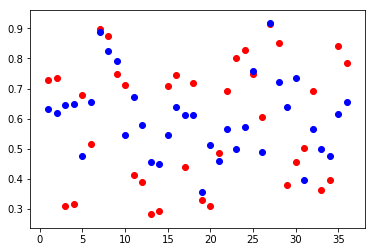

In [24]:
x = list(range(1, 37))
from matplotlib import pyplot as plt
plt.scatter(x, lstm_moy, color="red")
plt.scatter(x, human_moy, color="blue")

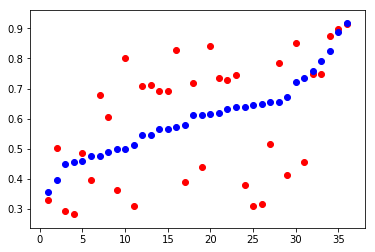

In [25]:
sorter = np.argsort(human_moy)
plt.scatter(x, lstm_moy[sorter], color="red")
plt.scatter(x, human_moy[sorter], color="blue")

In [26]:
print("lstm average:", round(np.mean(lstm_moy),3))
print("human average:", round(np.mean(human_moy),3))

lstm average: 0.597
human average: 0.603


In [27]:
print("lstm std:", round(np.std(lstm_moy),2))
print("human std:",round(np.std(human_moy),2))

lstm std: 0.2
human std: 0.13


In [28]:
np.corrcoef(lstm_moy, human_moy)

array([[ 1.        ,  0.53135119],
       [ 0.53135119,  1.        ]])

In [74]:
idx_0 = [6,7,26,27]
idx_1 = [0, 1, 14, 15, 22, 23, 34, 35]
idx_2 = [8,9,10,11,24,25,28,29]
idx_3 = [i for i in range(36) if i not in (idx_0 + idx_1 + idx_2)]

print("Fonction canonique, ordre canonique")
print("LSTM:", round(lstm_moy[[i for i in idx_0]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_0]].mean(),2), '\n')

print("Fonction non canonique, ordre canonique")
print("LSTM:", round(lstm_moy[[i for i in idx_1]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_1]].mean(),2), '\n')

print("Fonction canonique, ordre non canonique")
print("LSTM:", round(lstm_moy[[i for i in idx_2]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_2]].mean(),2), '\n')

print("Fonction non canonique, ordre non canonique")
print("LSTM:", round(lstm_moy[[i for i in idx_3]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_3]].mean(),2), '\n')

print("Total LSTM:", round(lstm_moy[[i for i in (idx_0 + idx_1 + idx_2 + idx_3)]].mean(),3))
print("Total Human:", round(human_moy[[i for i in (idx_0 + idx_1 + idx_2 + idx_3)]].mean(),3))

Fonction canonique, ordre canonique
LSTM: 0.88
Human: 0.84 

Fonction non canonique, ordre canonique
LSTM: 0.77
Human: 0.6 

Fonction canonique, ordre non canonique
LSTM: 0.56
Human: 0.65 

Fonction non canonique, ordre non canonique
LSTM: 0.46
Human: 0.52 

Total LSTM: 0.597
Total Human: 0.603


In [90]:
print("Fonction canonique, ordre canonique", '\n')

print("Most canonical order: Nom-Dat-Acc")
print("LSTM:", round(lstm_moy[[6,26]].mean(),2))
print("Human:", round(human_moy[[6,26]].mean(),2), '\n')

# Cannot see a reason for the slight difference in score below. 
# Template sentence was #6. #26 might sometimes be slightly less meaningful.

print("LSTM:", round(lstm_moy[26].mean(),2))
print("Human:", round(human_moy[26].mean(),2), '\n')

print("LSTM:", round(lstm_moy[6].mean(),2))
print("Human:", round(human_moy[6].mean(),2), '\n')


print("Second canonical order: Nom-Acc-Dat")
print("LSTM:", round(lstm_moy[[7,27]].mean(),2))
print("Human:", round(human_moy[[7,27]].mean(),2), '\n')

# Like sentence #26, #27 is slightly less meaningful, which might account for the drop in result between #7 and #27.
# Ex: le patient prescrit un vaccin au médecin, au lieu de l'inverse.
print("LSTM:", round(lstm_moy[7].mean(),2))
print("Human:", round(human_moy[7].mean(),2), '\n')

print("LSTM:", round(lstm_moy[27].mean(),2))
print("Human:", round(human_moy[27].mean(),2), '\n')

Fonction canonique, ordre canonique 

Most canonical order: Nom-Dat-Acc
LSTM: 0.9
Human: 0.9 

LSTM: 0.91
Human: 0.92 

LSTM: 0.9
Human: 0.89 

Second canonical order: Nom-Acc-Dat
LSTM: 0.86
Human: 0.77 

LSTM: 0.87
Human: 0.83 

LSTM: 0.85
Human: 0.72 



In [78]:
idx_4 = [0,1,6,7,14,15,22,23,26,27,34,35]
idx_5 = [2,3,10,11,12,13,18,19,28,29,32,33]
idx_6 = [i for i in range(36) if i not in (idx_4 + idx_5)]

print("Subordonnée commence par Nominatif")
print("LSTM:", round(lstm_moy[[i for i in idx_4]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_4]].mean(),2), '\n')

print("Subordonnée commence par Accusatif")
print("LSTM:", round(lstm_moy[[i for i in idx_5]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_5]].mean(),2), '\n')

print("Subordonnée commence par Datif")
print("LSTM:", round(lstm_moy[[i for i in idx_6]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_6]].mean(),2), '\n')

print("Total LSTM:", round(lstm_moy[[i for i in (idx_4 + idx_5 + idx_6)]].mean(),3))
print("Total Human:", round(human_moy[[i for i in (idx_4 + idx_5 + idx_6)]].mean(),3))

Subordonnée commence par Nominatif
LSTM: 0.81
Human: 0.68 

Subordonnée commence par Accusatif
LSTM: 0.35
Human: 0.56 

Subordonnée commence par Datif
LSTM: 0.63
Human: 0.58 

Total LSTM: 0.597
Total Human: 0.603


In [102]:
idx_7 = [18,19,20,21,22,23,30,31,32,33,34,35]
idx_8 = [6,7,8,9,10,11,24,25,26,27,28,29]
idx_9 = [0,1,2,3,4,5,12,13,14,15,16,17]

### Attention: limiter aux phrases concernées

print("Nominatif Animé")
print("LSTM:", round(lstm_moy[[i for i in range(36) if i not in idx_7]].mean(),2))
print("Human:", round(human_moy[[i for i in range(36) if i not in idx_7]].mean(),2), '\n')

print("Nominatif Inanimé")
print("LSTM:", round(lstm_moy[[i for i in idx_7]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_7]].mean(),2), '\n')

# Conclusion nominatif: Préférence lstm et humains pour nominatif animé

print("Accusatif Animé")
print("LSTM:", round(lstm_moy[[i for i in range(36) if i not in idx_8]].mean(),2))
print("Human:", round(human_moy[[i for i in range(36) if i not in idx_8]].mean(),2), '\n')

print("Accusatif Inanimé")
print("LSTM:", round(lstm_moy[[i for i in idx_8]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_8]].mean(),2), '\n')

# Conclusion accusatif: Préférence lstm et humains pour accusatif inanimé

print("Datif Animé")
print("LSTM:", round(lstm_moy[[i for i in range(36) if i not in idx_9]].mean(),2))
print("Human:", round(human_moy[[i for i in range(36) if i not in idx_9]].mean(),2), '\n')

print("Datif Inanimé")
print("LSTM:", round(lstm_moy[[i for i in idx_9]].mean(),2))
print("Human:", round(human_moy[[i for i in idx_9]].mean(),2), '\n')
 # Conclusion datif

Nominatif Animé
LSTM: 0.6
Human: 0.65 

Nominatif Inanimé
LSTM: 0.59
Human: 0.51 

Accusatif Animé
LSTM: 0.56
Human: 0.55 

Accusatif Inanimé
LSTM: 0.67
Human: 0.71 

Datif Animé
LSTM: 0.63
Human: 0.61 

Datif Inanimé
LSTM: 0.54
Human: 0.58 



### Conclusion animacy / inanimacy:

#### Attention: 10 templates (1/5) sont à exclure de l'analyse présente -> à paufiner
- lstm et humains (surtout) préfèrent le nominatif animé
- lstm et humains (surtout) préfèrent l'accusatif inanimé
- lstm (surtout) et humains préfèrent le datif animé